In [10]:
# coding: utf-8
'''公式的手写版在寝室草稿纸'''
import scipy.integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from numba import jit
import time as tm

In [11]:
################### Parameters ###################
# How many junctions
N = 10
# Normalized parameters
alpha0 = 0.1
gamma0 = 0.5
a0 = 1.0
# Time arange to solve in the calculation
time_step = 0.01
time_range = 600
time = np.arange(0, time_range, time_step)

################### Initial Conditions ###################
y0 = np.zeros(2 * N)

In [12]:
################### Calculations ###################
#@jit
def phi_tt(y, t, a = 1., alpha = 0.1, gamma = 0.5):
    '''
    phi_t and phi_tt return the slope of phi and d(phi)/dt respectively.
    y is a vetor with length 6(=2 * 3).
    y[0]~y[6] is phi_(n-1), d(phi_(n-1))/dt, phi_(n), d(phi_(n))/dt, phi_(n+1), d(phi_(n+1))/dt, respectively.
    '''  
    pass
    re = -alpha * y[3] - np.sin(y[2]) - (gamma + np.sin(t)) + (y[0] - 2 * y[2] + y[4]) / a**2
    #print 'aaaaaaa'
    #print gamma
    #print 'aaaaaaa'
    return re

#@jit
def every_six(y, t, a = 1., alpha = 0.1, gamma = 0.5):
    '''
    Each time, use 6 of the y array to calculate phi_tt.
    '''
    LEN = len(y)
    LEN2 = LEN / 2
    re = np.zeros(LEN2)
    #TODO maybe useful: np.apply_along_axis(fun, axis=1, array)
    re[0] = phi_tt(np.hstack((y[-2:], y[:4])), t, a, alpha, gamma)
    for i in np.arange(1, LEN2 - 1):
        re[i] = phi_tt(y[2 * i - 2: 2 * i + 4], t, a, alpha, gamma)
    re[LEN2 - 1] = phi_tt(np.hstack((y[-4:], y[:2])), t, a, alpha, gamma)
    return re

#@jit
def myfunc(y, t, a = 1., alpha = 0.1, gamma = 0.5):
    '''
    y is a vetor with length 2 * N. 
    y[0] ~ y[N] is phi1_t, phi1_tt, phi2_t, phi2_tt, ... , phiN_t, phiN_tt, respectively.
    '''
    LEN = len(y)
    re = np.zeros(LEN)
    index = np.arange(LEN)
    boolean_index_even = (index % 2 == 0)
    boolean_index_odd = (index % 2 == 1)

    re[boolean_index_even] = y[boolean_index_odd] #TODO 或者使用phi_t函数？画蛇添足吧
    re[boolean_index_odd] = every_six(y, t, a, alpha, gamma)
    return re

In [27]:
################### Test Plot ###################
#@jit
def myplot(f, y0, t, arguments=(a0, alpha0, gamma0)):
    '''
    Plot U-t and phi-t relation in two sub-figures
    '''
    # creat two sub-figures
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    # set title and label
    ax1.set_title('Time from 0 to %f. $\gamma$ = %f, alpha = %f, a = %f'
    % (time[len(time) - 1], arguments[2], arguments[1], arguments[0]))
    ax1.set_xlabel('Time t / s')
    ax1.set_ylabel('Phase $\phi$ / rad')
    ax2.set_xlabel('Time t / s')
    ax2.set_ylabel('Votage $U$ / V')
    # calculate using ODEINT function
    result = inte.odeint(f, y0, t, args=arguments)
    # plot a horizonal line at y = 0
    ax2.plot(time, np.zeros(len(time)))
    for i in np.arange(len(y0) / 2):
        ax1.plot(time, result[:, 2 * i], label='$\phi_{%d}$' % (i + 1)) 
        ax2.plot(time, result[:, 2 * i + 1], label='$U_{%d}$' % (i + 1))
    # location of the legends
    ax1.legend(loc="best")    
    ax2.legend(loc="best")
    plt.savefig('comp.results/alpha = %f.png' % arguments[2], dpi=144, format='png')
    plt.close()
    #plt.show()

In [5]:
judge = 1
if (judge):
    ################### Plot gamma-U curve ###################
    gamma_step = 0.01
    gamma_array = np.arange(-3., 3., gamma_step)
    gamma_U_array = np.zeros([len(gamma_array), N + 1])
    counter = 0
    for mygamma in gamma_array:
        argu3 = (a0, alpha0, mygamma)
        result = inte.odeint(myfunc, y0, time, argu3)
        cut = 100.
        cut_index = np.int(cut / time_step)
        result_cut = result[cut_index: , :]
        index = np.arange(result_cut.shape[1])
        boolean_index_even = (index % 2 == 0)
        boolean_index_odd = (index % 2 == 1)
        result_cut_U = result_cut[:, boolean_index_odd]
        U_mean = np.mean(result_cut_U, axis=0)
        gamma_U_array[counter, 1:] = U_mean
        print "\n\ncounter = %f, mygamma = %f" %(counter, mygamma)
    #     print U_mean
        counter += 1
    gamma_U_array[:, 0] = gamma_array
    np.save('comp.results/gamma_U_array', gamma_U_array)
    plt.figure(figsize=(12,8))
    plt.plot(gamma_U_array[:, 0], gamma_U_array[:, 1], lw=1.5)
    plt.xlabel("$\gamma$")
    plt.ylabel("$U$ (normalized)")
    plt.title(r'Time from %f to %f. a = %f, $\alpha$ = %f, $\gamma$ step = %f'
    % (cut, time_range, argu3[0], argu3[1], gamma_step))
    plt.show()
else:
    ################### Plot phi-t, U-t at different gamma value ###################
    # Time it
    print tm.clock()
    gamma_array = np.arange(20, 21, 1)
    for mygamma in gamma_array:
        argu3 = (a0, alpha0, mygamma)
        myplot(myfunc, y0, time, argu3)  
        print "mygamma = %f" % mygamma + "is done.\n"
    # Time it again
    print tm.clock()
    plt.show()



counter = 0.000000, mygamma = -3.000000


KeyboardInterrupt: 

上面是完整程序代码 下面是测试

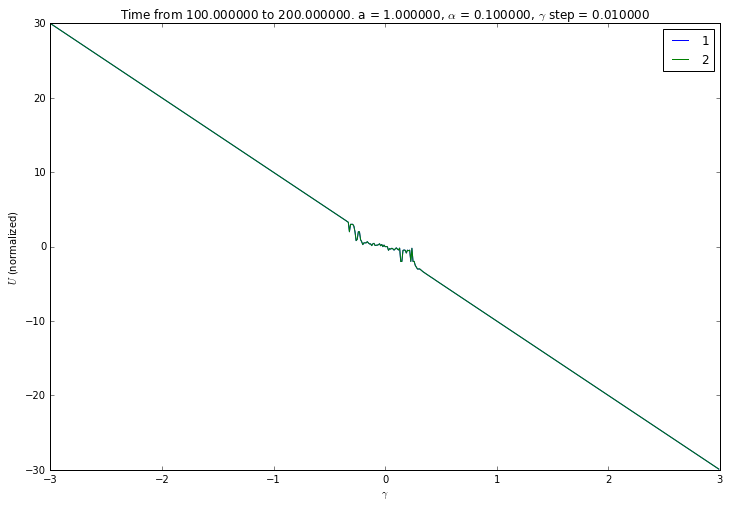

In [10]:
argu3 = (a0, alpha0, 0.)
cut = 100.
gamma_step = 0.01
gamma_U_array = np.load('comp.results/gamma_U_array.npy')
plt.figure(figsize=(12,8))
plt.plot(gamma_U_array[:, 0], gamma_U_array[:, 1], lw=1., label="1")
plt.plot(gamma_U_array[:, 0], gamma_U_array[:, 2], lw=1., label="2")
plt.xlabel("$\gamma$")
plt.ylabel("$U$ (normalized)")
plt.title(r'Time from %f to %f. a = %f, $\alpha$ = %f, $\gamma$ step = %f'
% (cut, time_range, argu3[0], argu3[1], gamma_step))
plt.legend(loc="best")
plt.show()

In [11]:
gamma_U_array.shape

(600L, 9L)

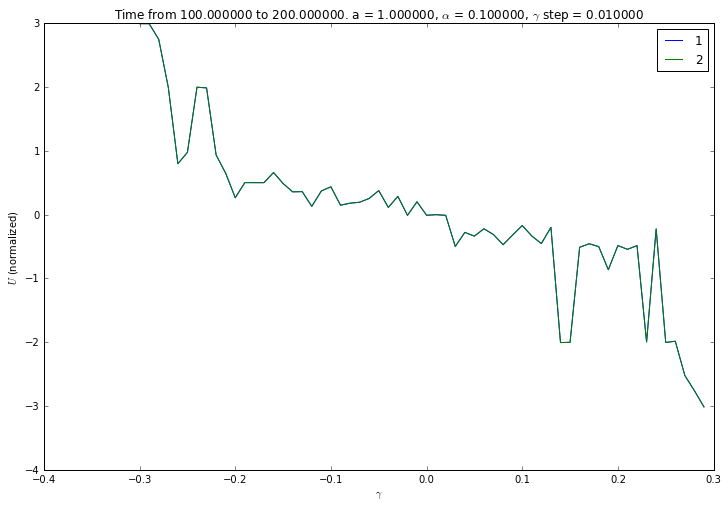

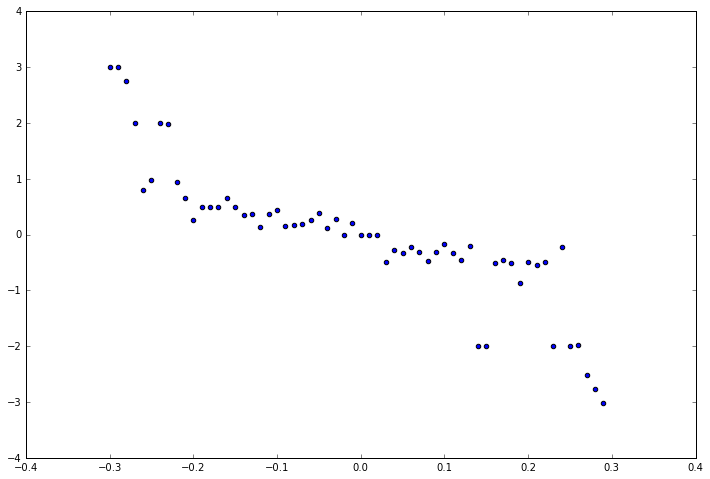

In [20]:
a, b = 270, 330
argu3 = (a0, alpha0, 0.)
cut = 100.
gamma_step = 0.01
gamma_U_array = np.load('comp.results/gamma_U_array.npy')
plt.figure(figsize=(12,8))
plt.plot(gamma_U_array[a:b, 0], gamma_U_array[a:b, 1], lw=1., label="1")
plt.plot(gamma_U_array[a:b, 0], gamma_U_array[a:b, 2], lw=1., label="2")
plt.xlabel("$\gamma$")
plt.ylabel("$U$ (normalized)")
plt.title(r'Time from %f to %f. a = %f, $\alpha$ = %f, $\gamma$ step = %f'
% (cut, time_range, argu3[0], argu3[1], gamma_step))
plt.legend(loc="best")
plt.figure(figsize=(12,8))
plt.scatter(gamma_U_array[a:b, 0], gamma_U_array[a:b, 1], lw=1., label="1")

In [6]:
%matplotlib inline

In [29]:
gamma_array = np.arange(0.00, 0.305, 0.01)
for mygamma in gamma_array:
    argu3 = (a0, alpha0, mygamma)
    myplot(myfunc, y0, time, argu3)
    print "mygamma = %f" % mygamma + "is done.\n"

mygamma = 0.005000is done.

mygamma = 0.015000is done.

mygamma = 0.025000is done.

mygamma = 0.035000is done.

mygamma = 0.045000is done.

mygamma = 0.055000is done.

mygamma = 0.065000is done.

mygamma = 0.075000is done.

mygamma = 0.085000is done.

mygamma = 0.095000is done.

mygamma = 0.105000is done.

mygamma = 0.115000is done.

mygamma = 0.125000is done.

mygamma = 0.135000is done.

mygamma = 0.145000is done.

mygamma = 0.155000is done.

mygamma = 0.165000is done.

mygamma = 0.175000is done.

mygamma = 0.185000is done.

mygamma = 0.195000is done.

mygamma = 0.205000is done.

mygamma = 0.215000is done.

mygamma = 0.225000is done.

mygamma = 0.235000is done.

mygamma = 0.245000is done.

mygamma = 0.255000is done.

mygamma = 0.265000is done.

mygamma = 0.275000is done.

mygamma = 0.285000is done.

mygamma = 0.295000is done.



In [62]:
gamma_array = np.arange(-2., 2., 0.1)
gamma_U_array = np.zeros([len(gamma_array), N + 1])
counter = 0
for mygamma in gamma_array:
    argu3 = (a0, alpha0, mygamma)
    result = inte.odeint(myfunc, y0, time, argu3)
    cut = 100.
    cut_index = np.int(cut / time_step)
    result_cut = result[cut_index: , :]
    index = np.arange(result_cut.shape[1])
    boolean_index_even = (index % 2 == 0)
    boolean_index_odd = (index % 2 == 1)
    result_cut_U = result_cut[:, boolean_index_odd]
    U_mean = np.mean(result_cut_U, axis=0)
    gamma_U_array[counter, 1:] = U_mean
#     print "\n\ncounter = %f, mygamma = %f" %(counter, mygamma)
#     print U_mean
    counter += 1
gamma_U_array[:, 0] = gamma_array
plt.plot(gamma_U_array[:, 0], gamma_U_array[:, 1])
plt.

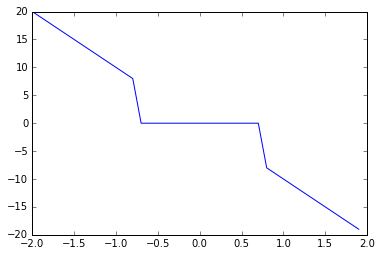

In [65]:
gamma_U_array[:, 0] = gamma_array
plt.plot(gamma_U_array[:, 0], gamma_U_array[:, 1])

In [64]:
gamma_U_array

array([[  1.99998089e+01,   1.99998089e+01,   1.99998089e+01,
          1.99998089e+01,   1.99998089e+01,   1.99998089e+01],
       [  1.89998889e+01,   1.89998889e+01,   1.89998889e+01,
          1.89998889e+01,   1.89998889e+01,   1.89998889e+01],
       [  1.79998137e+01,   1.79998137e+01,   1.79998137e+01,
          1.79998137e+01,   1.79998137e+01,   1.79998137e+01],
       [  1.69997781e+01,   1.69997781e+01,   1.69997781e+01,
          1.69997781e+01,   1.69997781e+01,   1.69997781e+01],
       [  1.59998849e+01,   1.59998849e+01,   1.59998849e+01,
          1.59998849e+01,   1.59998849e+01,   1.59998849e+01],
       [  1.49997393e+01,   1.49997393e+01,   1.49997393e+01,
          1.49997393e+01,   1.49997393e+01,   1.49997393e+01],
       [  1.39997565e+01,   1.39997565e+01,   1.39997565e+01,
          1.39997565e+01,   1.39997565e+01,   1.39997565e+01],
       [  1.29997216e+01,   1.29997216e+01,   1.29997216e+01,
          1.29997216e+01,   1.29997216e+01,   1.29997216e+01],


In [15]:
argu3 = (a0, alpha0, 0.8)
result = inte.odeint(myfunc, y0, time, argu3)

In [19]:
result.shape

(20000L, 12L)

In [20]:
LEN1 = result.shape[1]
index = np.arange(LEN1)
boolean_index_even = (index % 2 == 0)
boolean_index_odd = (index % 2 == 1)

In [21]:
boolean_index_even

array([ True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False], dtype=bool)

In [26]:
result[:, boolean_index_even][:, 3]==result[:, 6]

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [27]:
result_U = result[:, boolean_index_odd]

In [28]:
result_U.shape

(20000L, 6L)

In [29]:
U_mean = np.mean(result_U, axis=0)

In [31]:
U_mean

array([-7.42725486, -7.42725486, -7.42725486, -7.42725486, -7.42725486,
       -7.42725486])

[-7.99894098 -7.99894098 -7.99894098 -7.99894098 -7.99894098 -7.99894098]


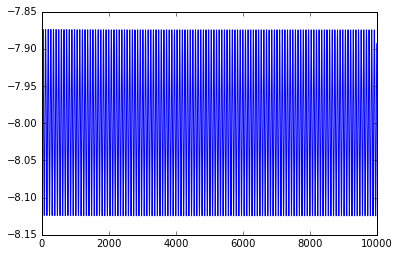

In [42]:
cut = 100.
cut_index = np.int(cut / time_step)
result_cut = result[cut_index: , :]
index = np.arange(result_cut.shape[1])
boolean_index_odd = (index % 2 == 1)
result_cut_U = result_cut[:, boolean_index_odd]
U_mean = np.mean(result_cut_U, axis=0)
print U_mean
plt.plot(result_cut_U[:,0])

[-7.42725486 -7.42725486 -7.42725486 -7.42725486 -7.42725486 -7.42725486]


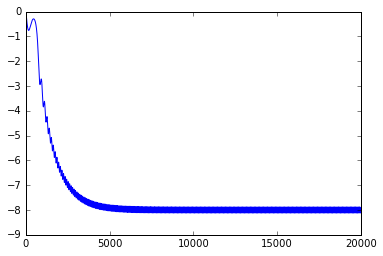

In [41]:
index = np.arange(result.shape[1])
result_U = result[:, boolean_index_odd]
U_mean2 = np.mean(result_U, axis=0)
print U_mean2
plt.plot(result_U[:,0])

In [43]:
gamma_U_array = np.zeros([len(gamma_array), N])

In [44]:
gamma_U_array.shape

(20L, 6L)